# Combining the Climatic variables of Alberta Region

In [ ]:
import os
import xarray as xr
import pandas as pd

# Define the directory containing the files
directory = r"C:\Users\DELL\OneDrive - iitr.ac.in\Documents\hydrclimatology_project"

# List all NetCDF files matching the naming pattern
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.nc4')]

# Initialize a dictionary to store the data for each variable
combined_data = {}

# Loop through each file to process
for file in files:
    try:
        # Open the dataset
        ds = xr.open_dataset(file)

        # For each variable in the dataset, concatenate the data along the 'time' dimension
        for var_name in ds.data_vars:
            # Check if the variable is already in the combined data dictionary
            if var_name in combined_data:
                # Concatenate the current variable's data with the previous ones along the 'time' dimension
                combined_data[var_name] = xr.concat([combined_data[var_name], ds[var_name]], dim='time')
            else:
                # If this is the first time, add the variable's data to the dictionary
                combined_data[var_name] = ds[var_name]

        # Convert the 'time' dimension to pandas datetime if necessary
        for var_name in ds.data_vars:
            if 'time' in ds[var_name].dims:
                ds[var_name]['time'] = pd.to_datetime(ds[var_name]['time'].values)

    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Sort data by time for each variable
for var_name in combined_data:
    combined_data[var_name] = combined_data[var_name].sortby('time')

# Combine all variables into a single xarray Dataset
combined_dataset = xr.Dataset(combined_data)

# Save the combined dataset to a new NetCDF file
output_file = os.path.join(directory, "combined_data.nc")
combined_dataset.to_netcdf(output_file)
print(f"Combined data saved to: {output_file}")


In [6]:
import xarray as xr
import pandas as pd

# Load the dataset
ds = xr.open_dataset(r"C:\Users\DELL\OneDrive - iitr.ac.in\Documents\hydrclimatology_project\combined_data.nc")

# Display all variable names
print("Variables in the dataset:", list(ds.data_vars))

# Choose a specific variable to display (e.g., 'Evap_tavg')
# You can replace 'Evap_tavg' with any variable name present in your dataset
variable_name = 'Evap_tavg'  # Replace with the desired variable

# Extract the variable as a DataArray
data = ds[variable_name]

# Convert the data to a pandas DataFrame
# We will use the time, latitude, and longitude as the index and columns
data_df = data.to_dataframe().reset_index()

# Display the first few rows of the DataFrame
print(f"\nDisplaying data for variable: {variable_name}")
print(data_df.head())  # Display first 5 rows, you can use data_df to display the entire table


Variables in the dataset: ['time_bnds', 'Evap_tavg', 'AvgSurfT_inst', 'Albedo_inst', 'PotEvap_tavg', 'ECanop_tavg', 'Tveg_tavg', 'ESoil_tavg', 'CanopInt_inst', 'Rainf_f_tavg', 'Tair_f_inst']

Displaying data for variable: Evap_tavg
        time     lat      lon     Evap_tavg
0 2000-01-01  49.125 -119.875  4.309710e-07
1 2000-01-01  49.125 -119.625  5.394388e-07
2 2000-01-01  49.125 -119.375  6.894388e-07
3 2000-01-01  49.125 -119.125  7.971000e-07
4 2000-01-01  49.125 -118.875  1.243471e-06


<h2>Spatial Analysis of Climatic variables</h2>

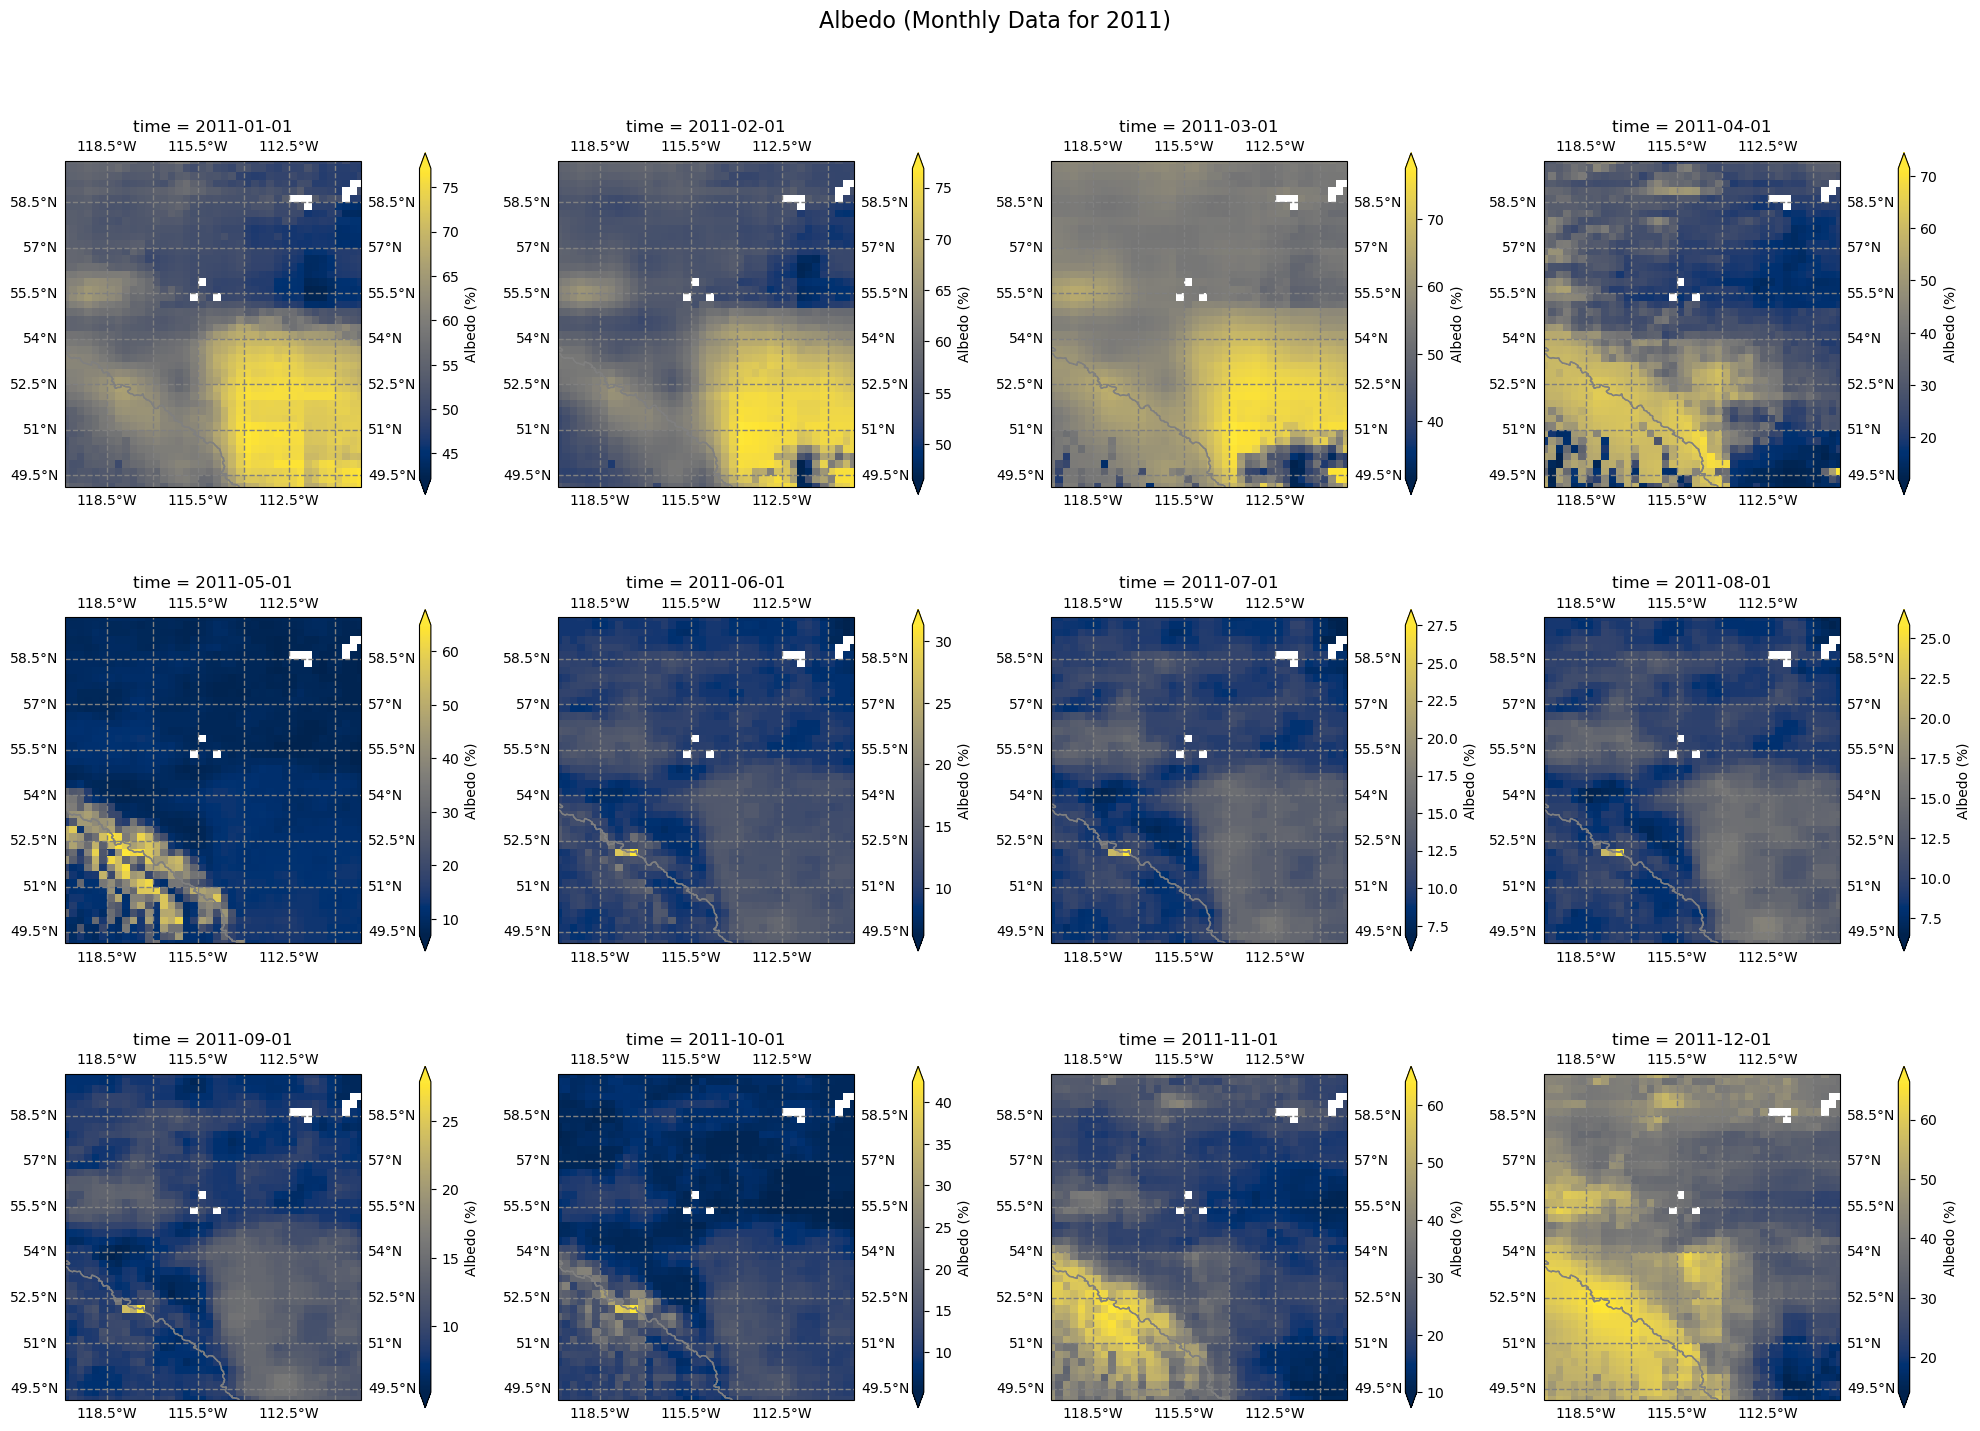

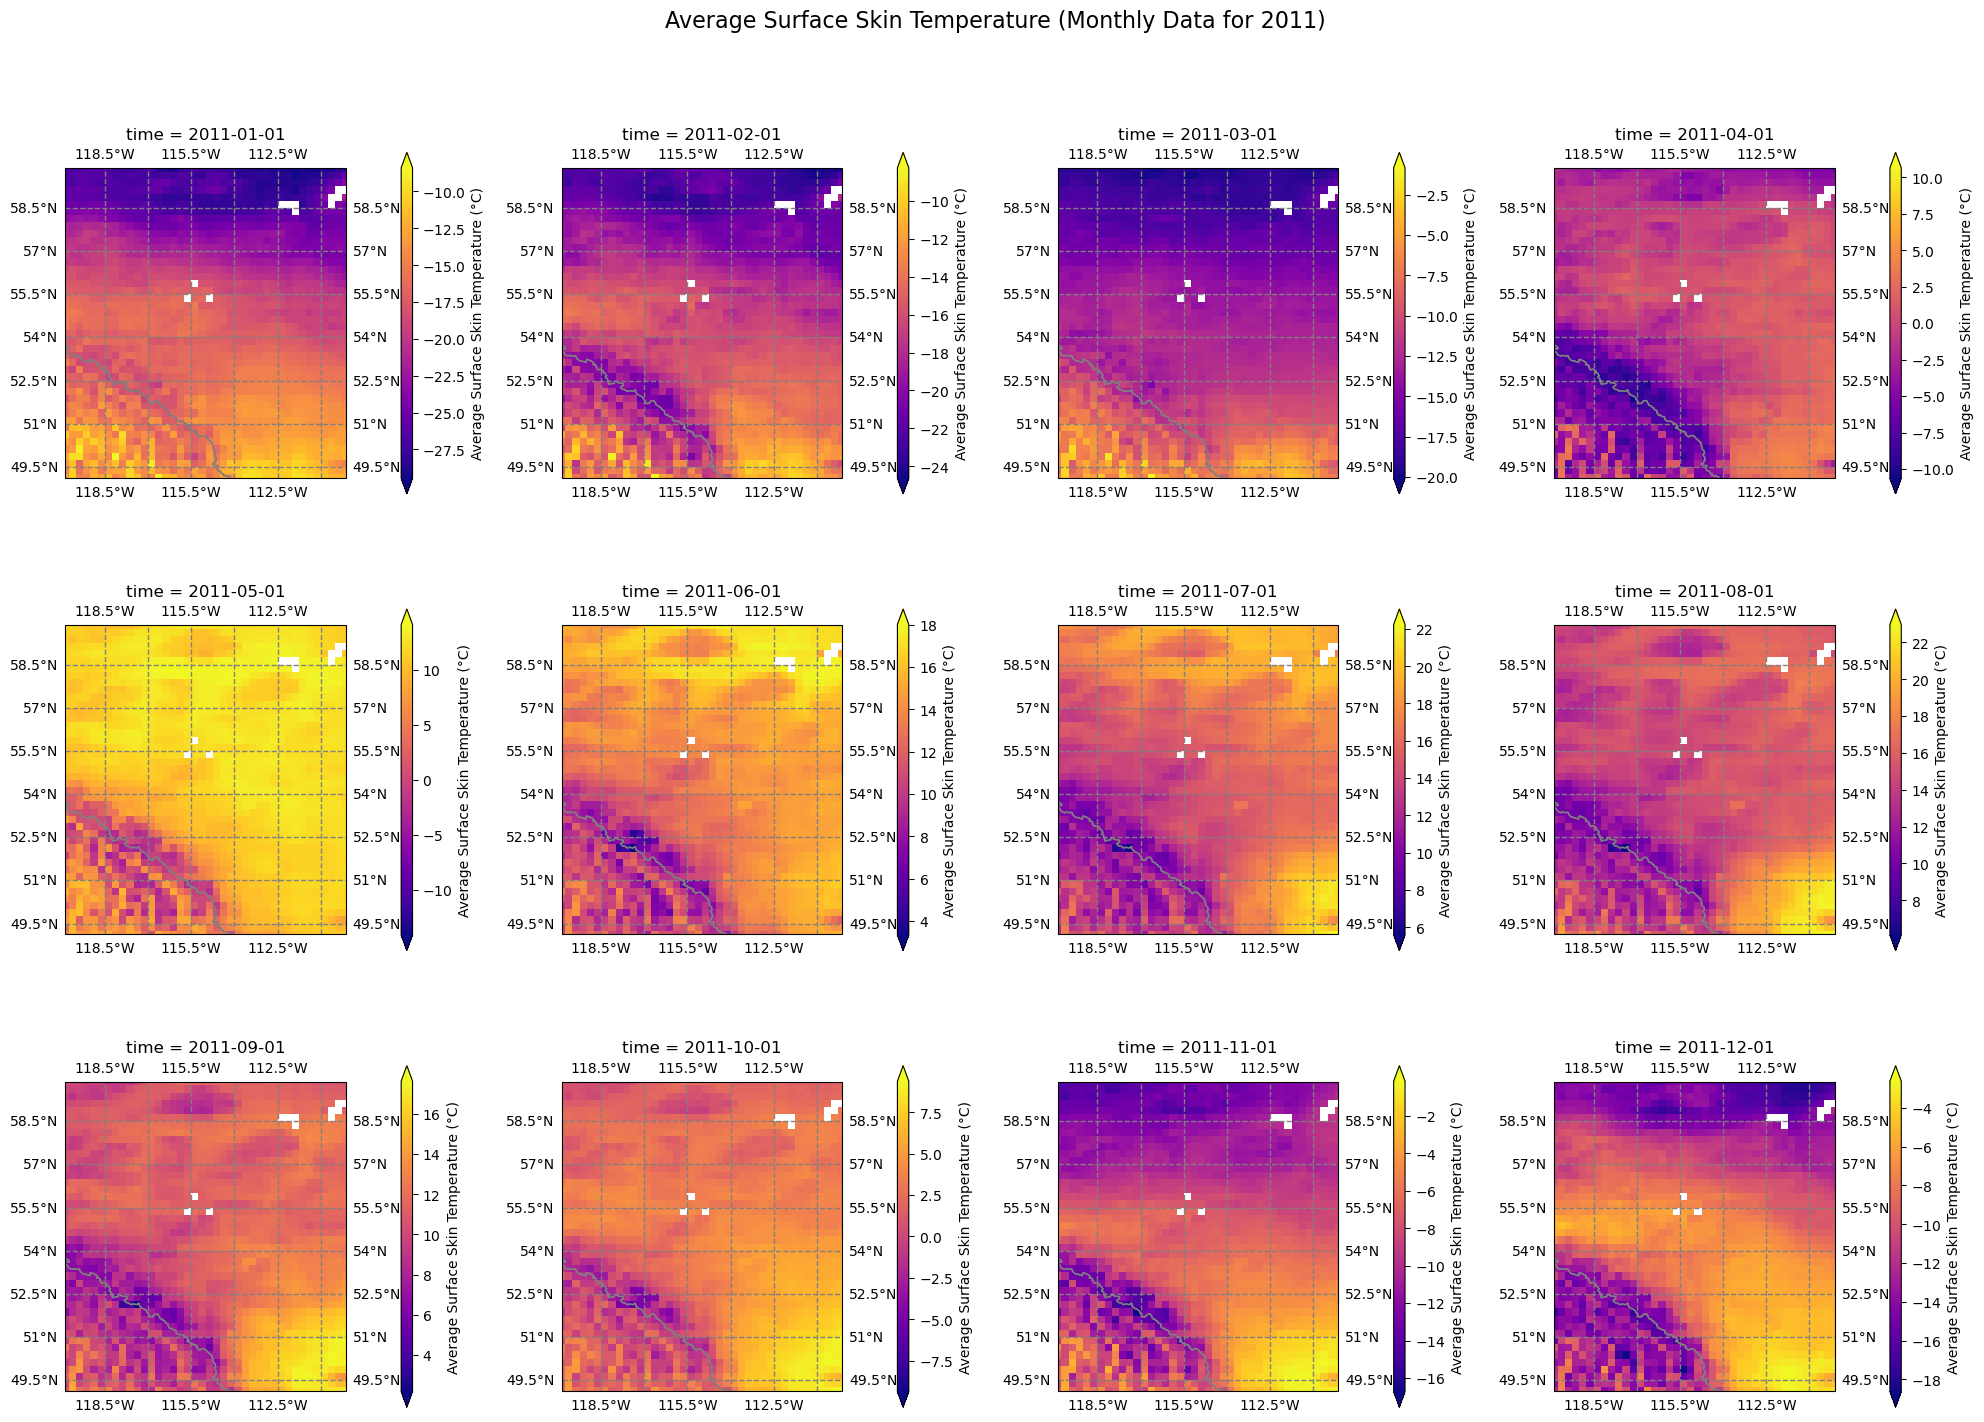

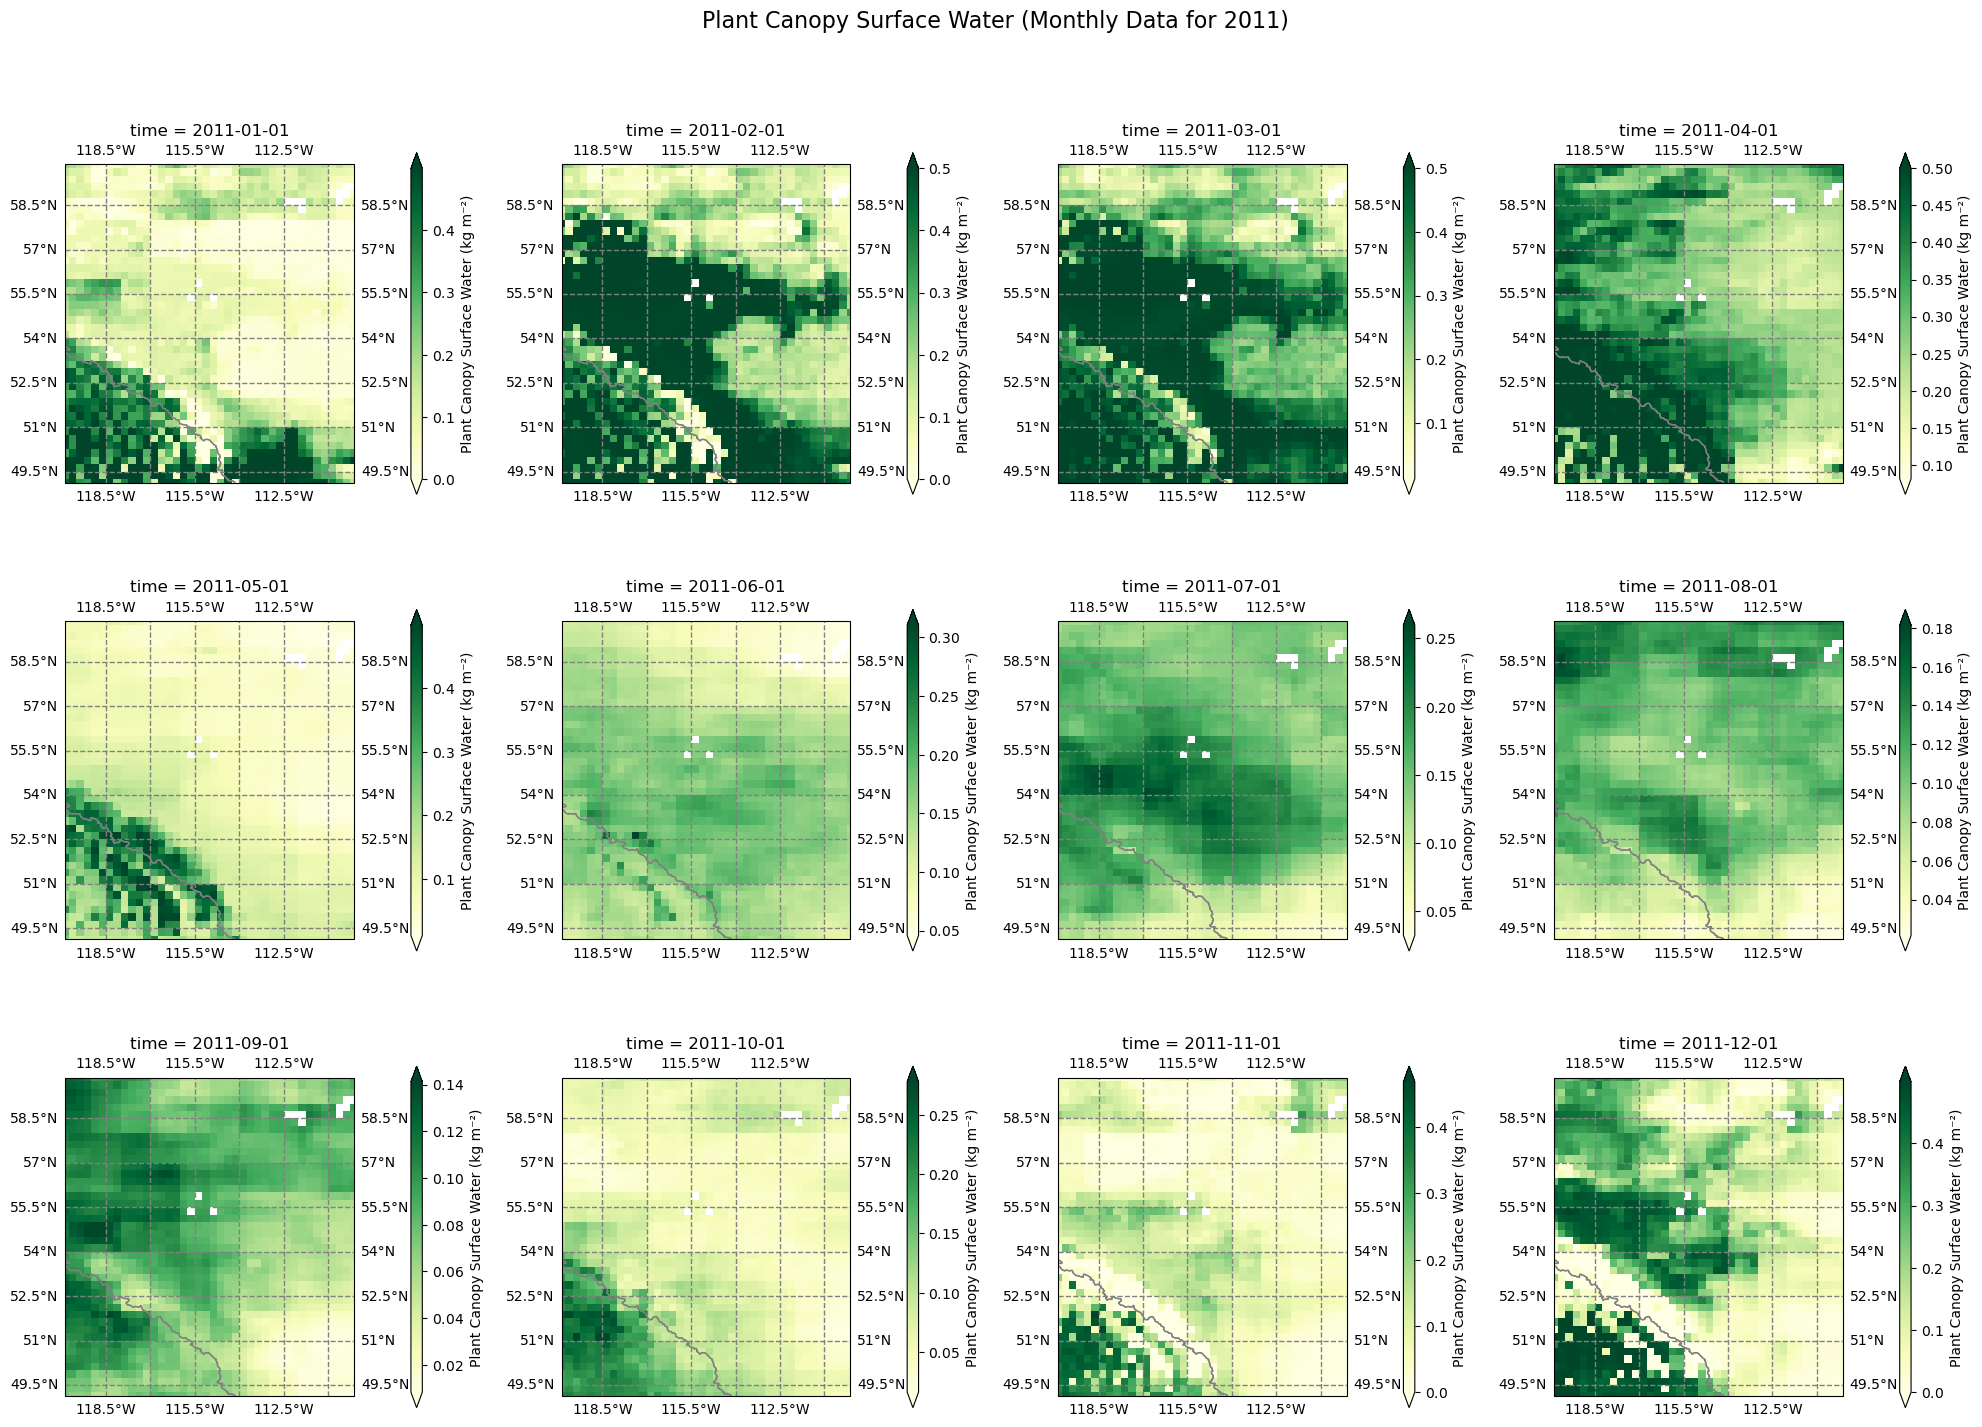

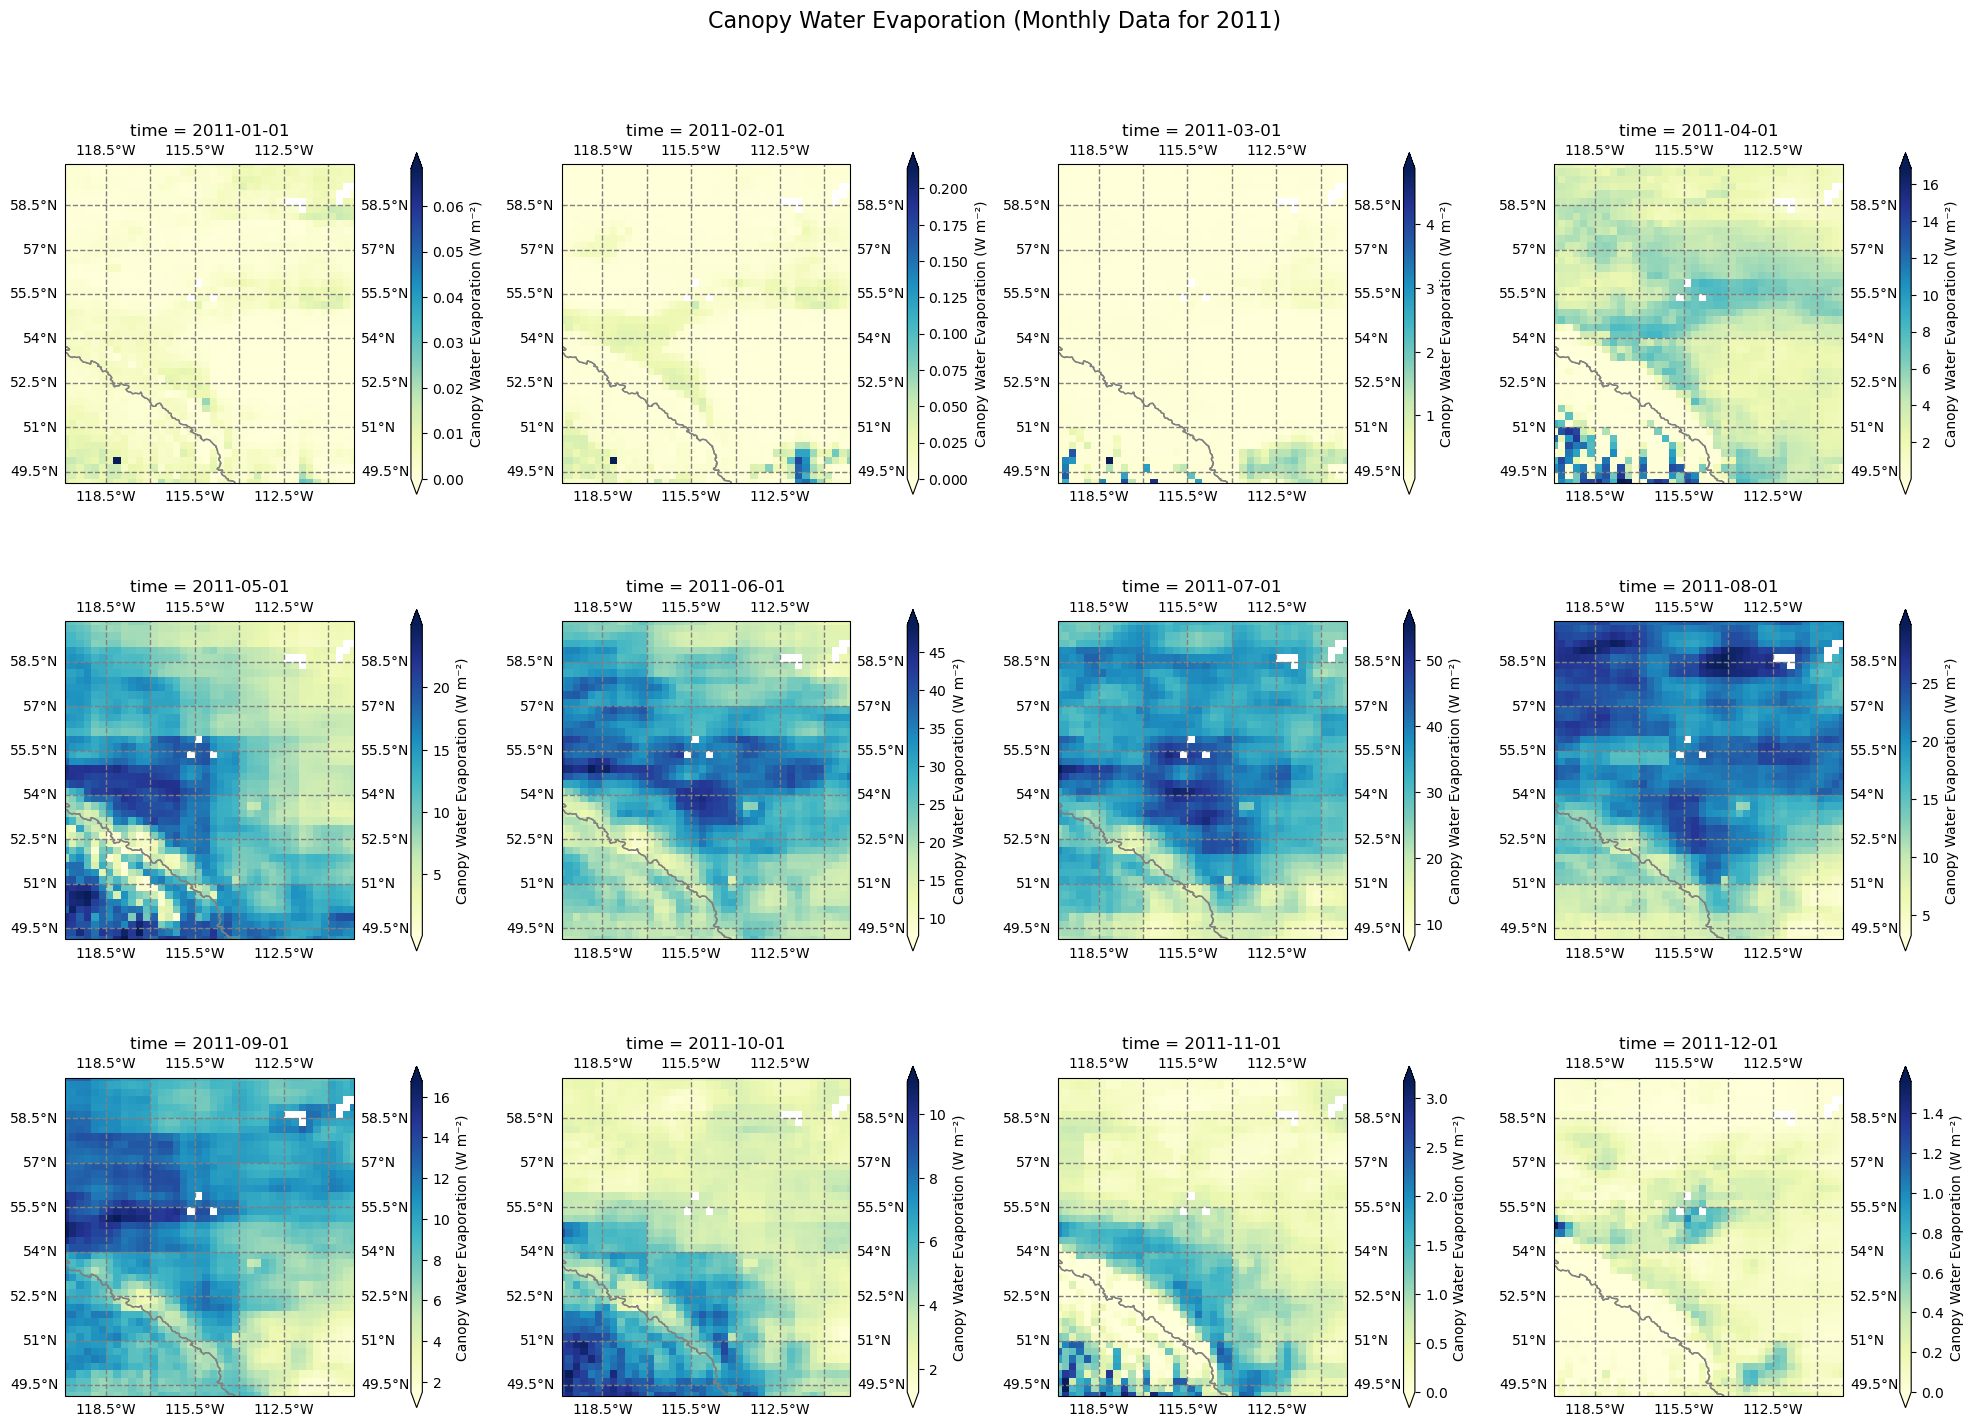

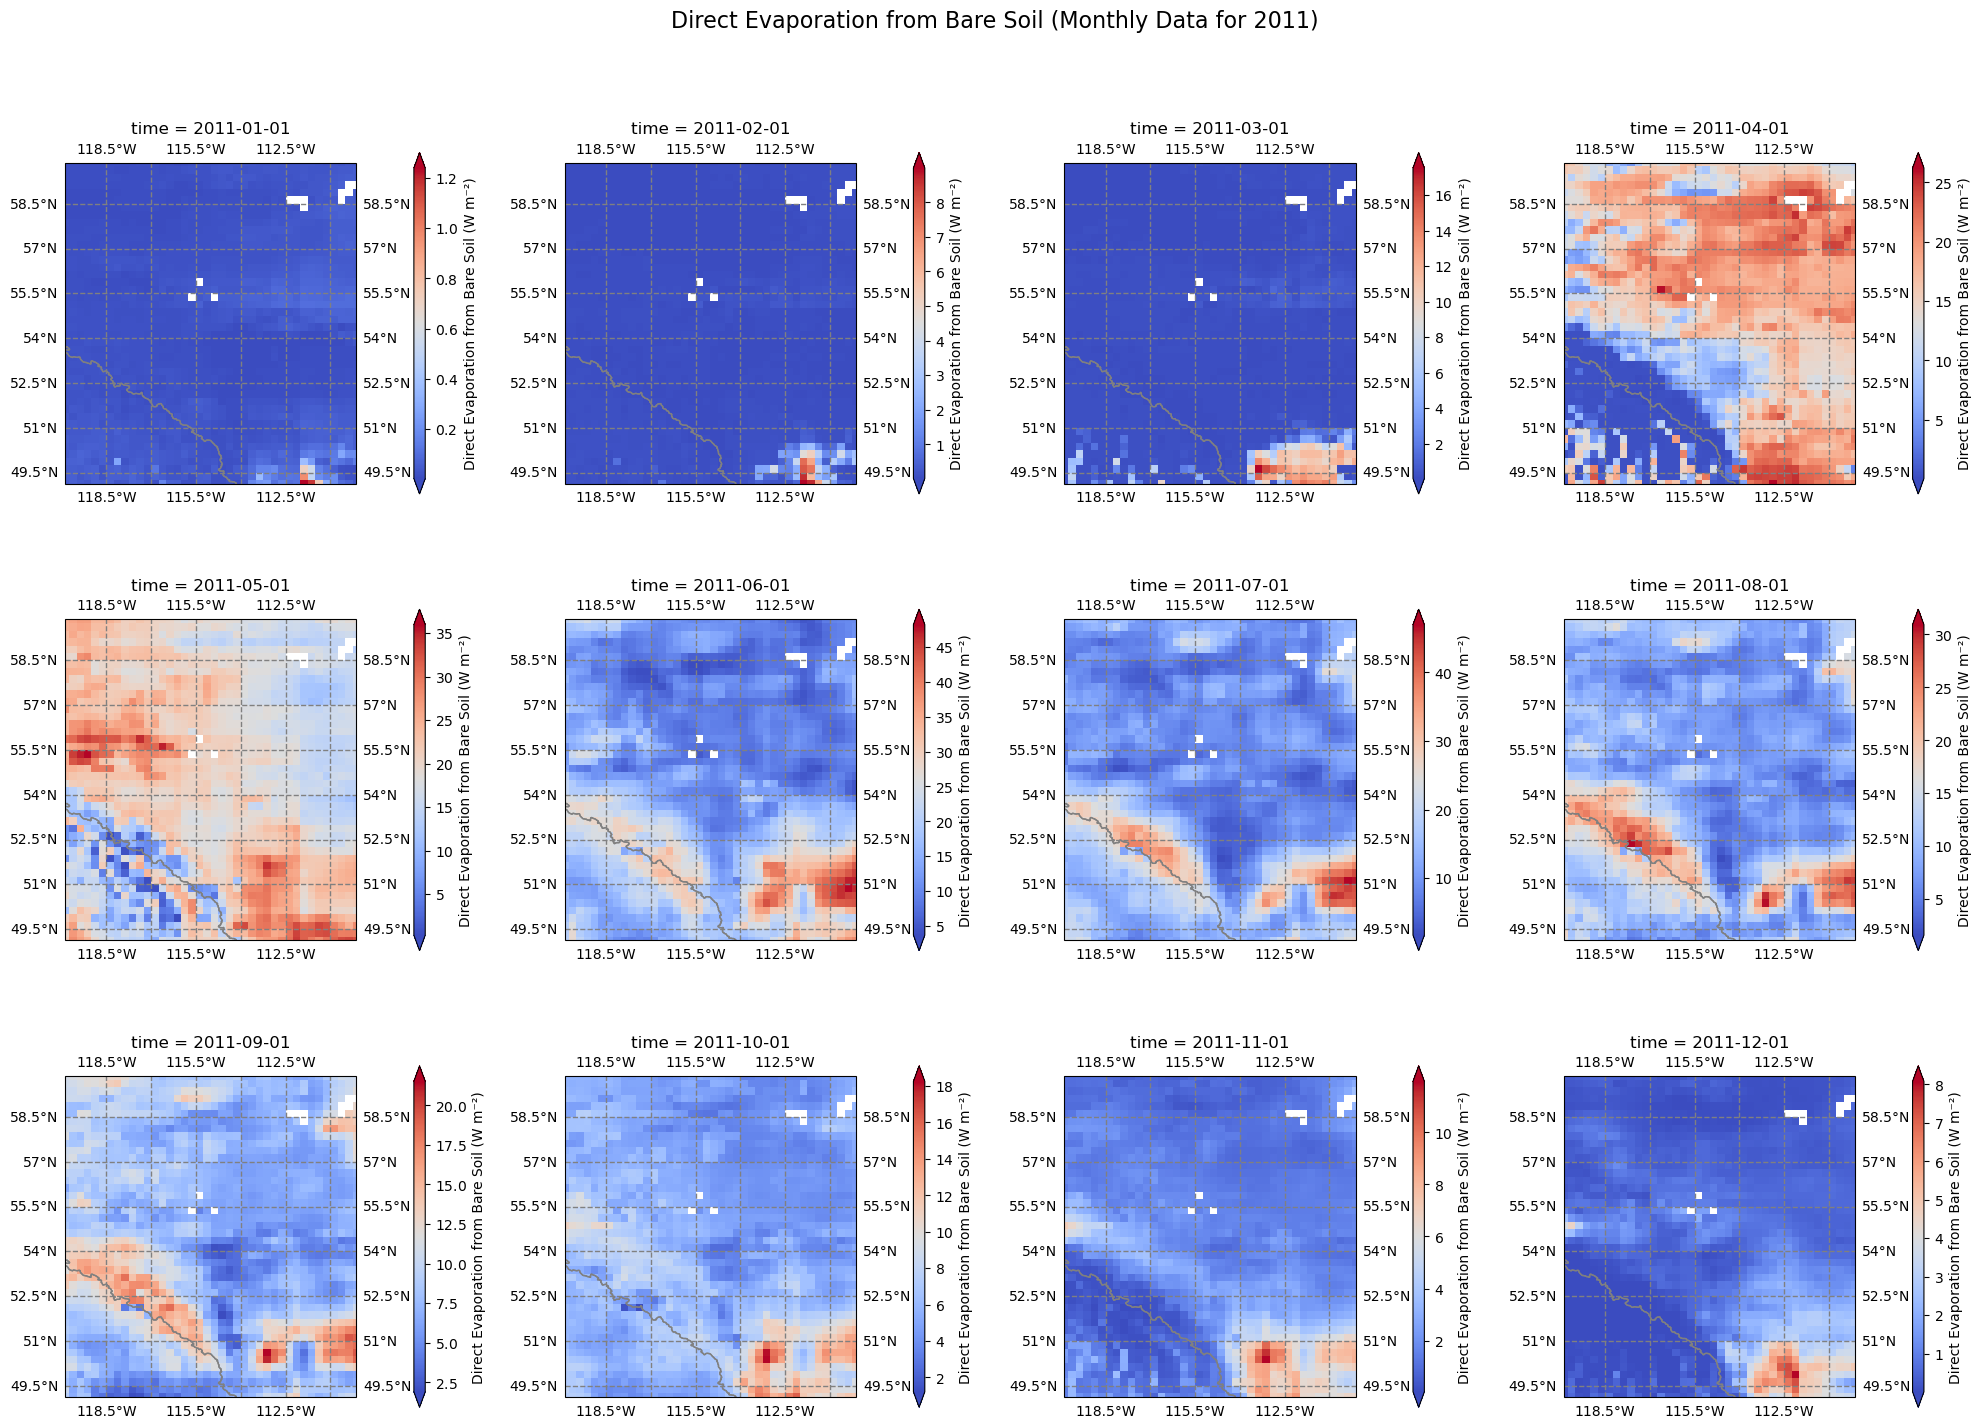

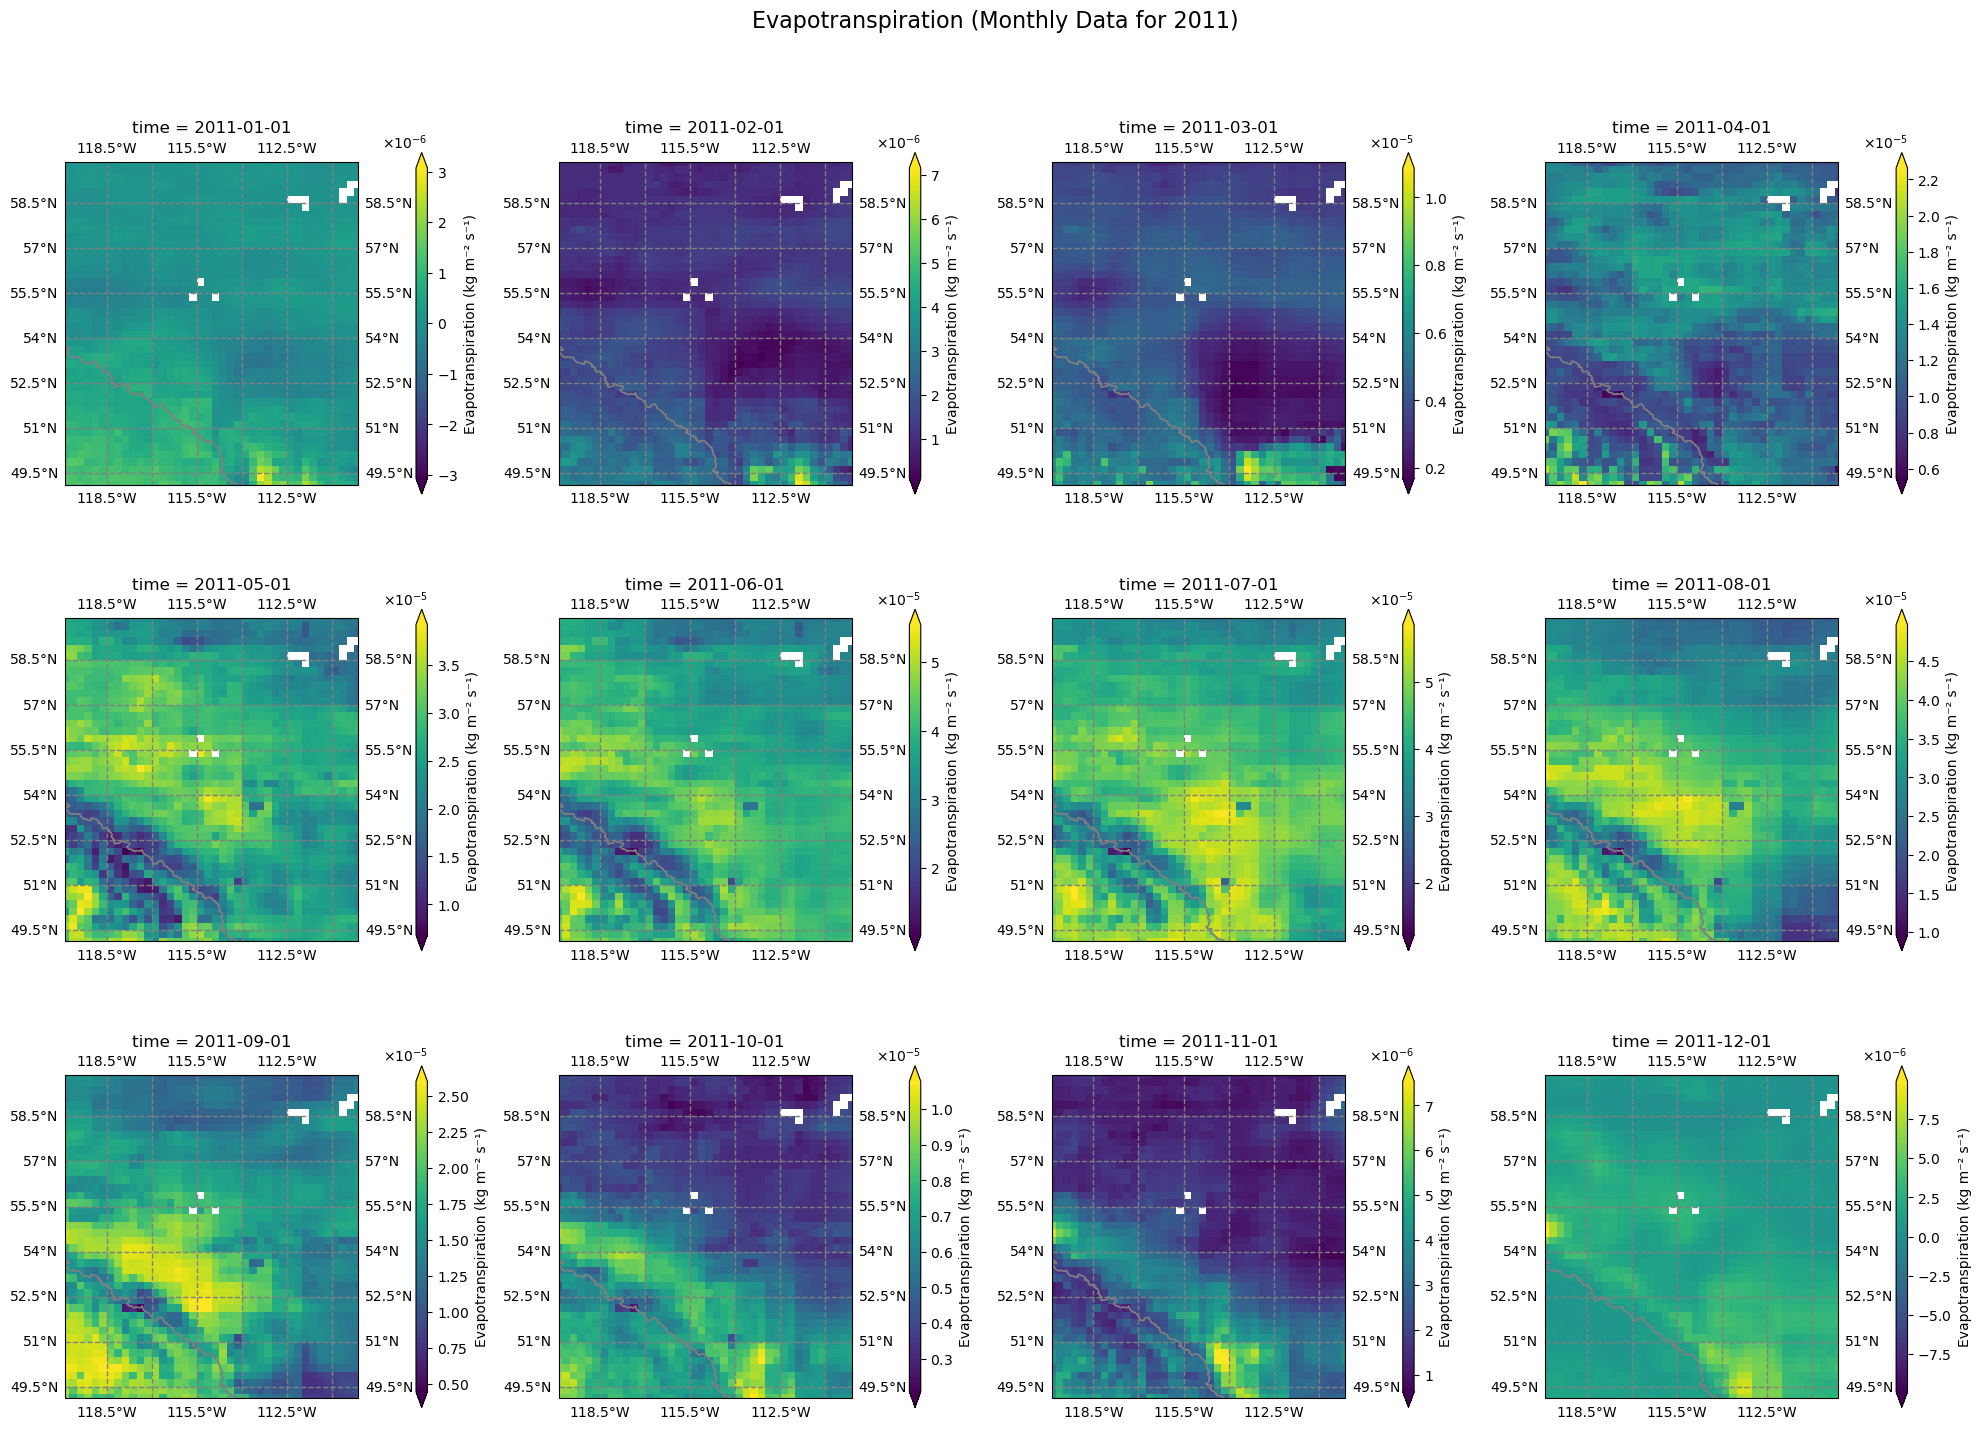

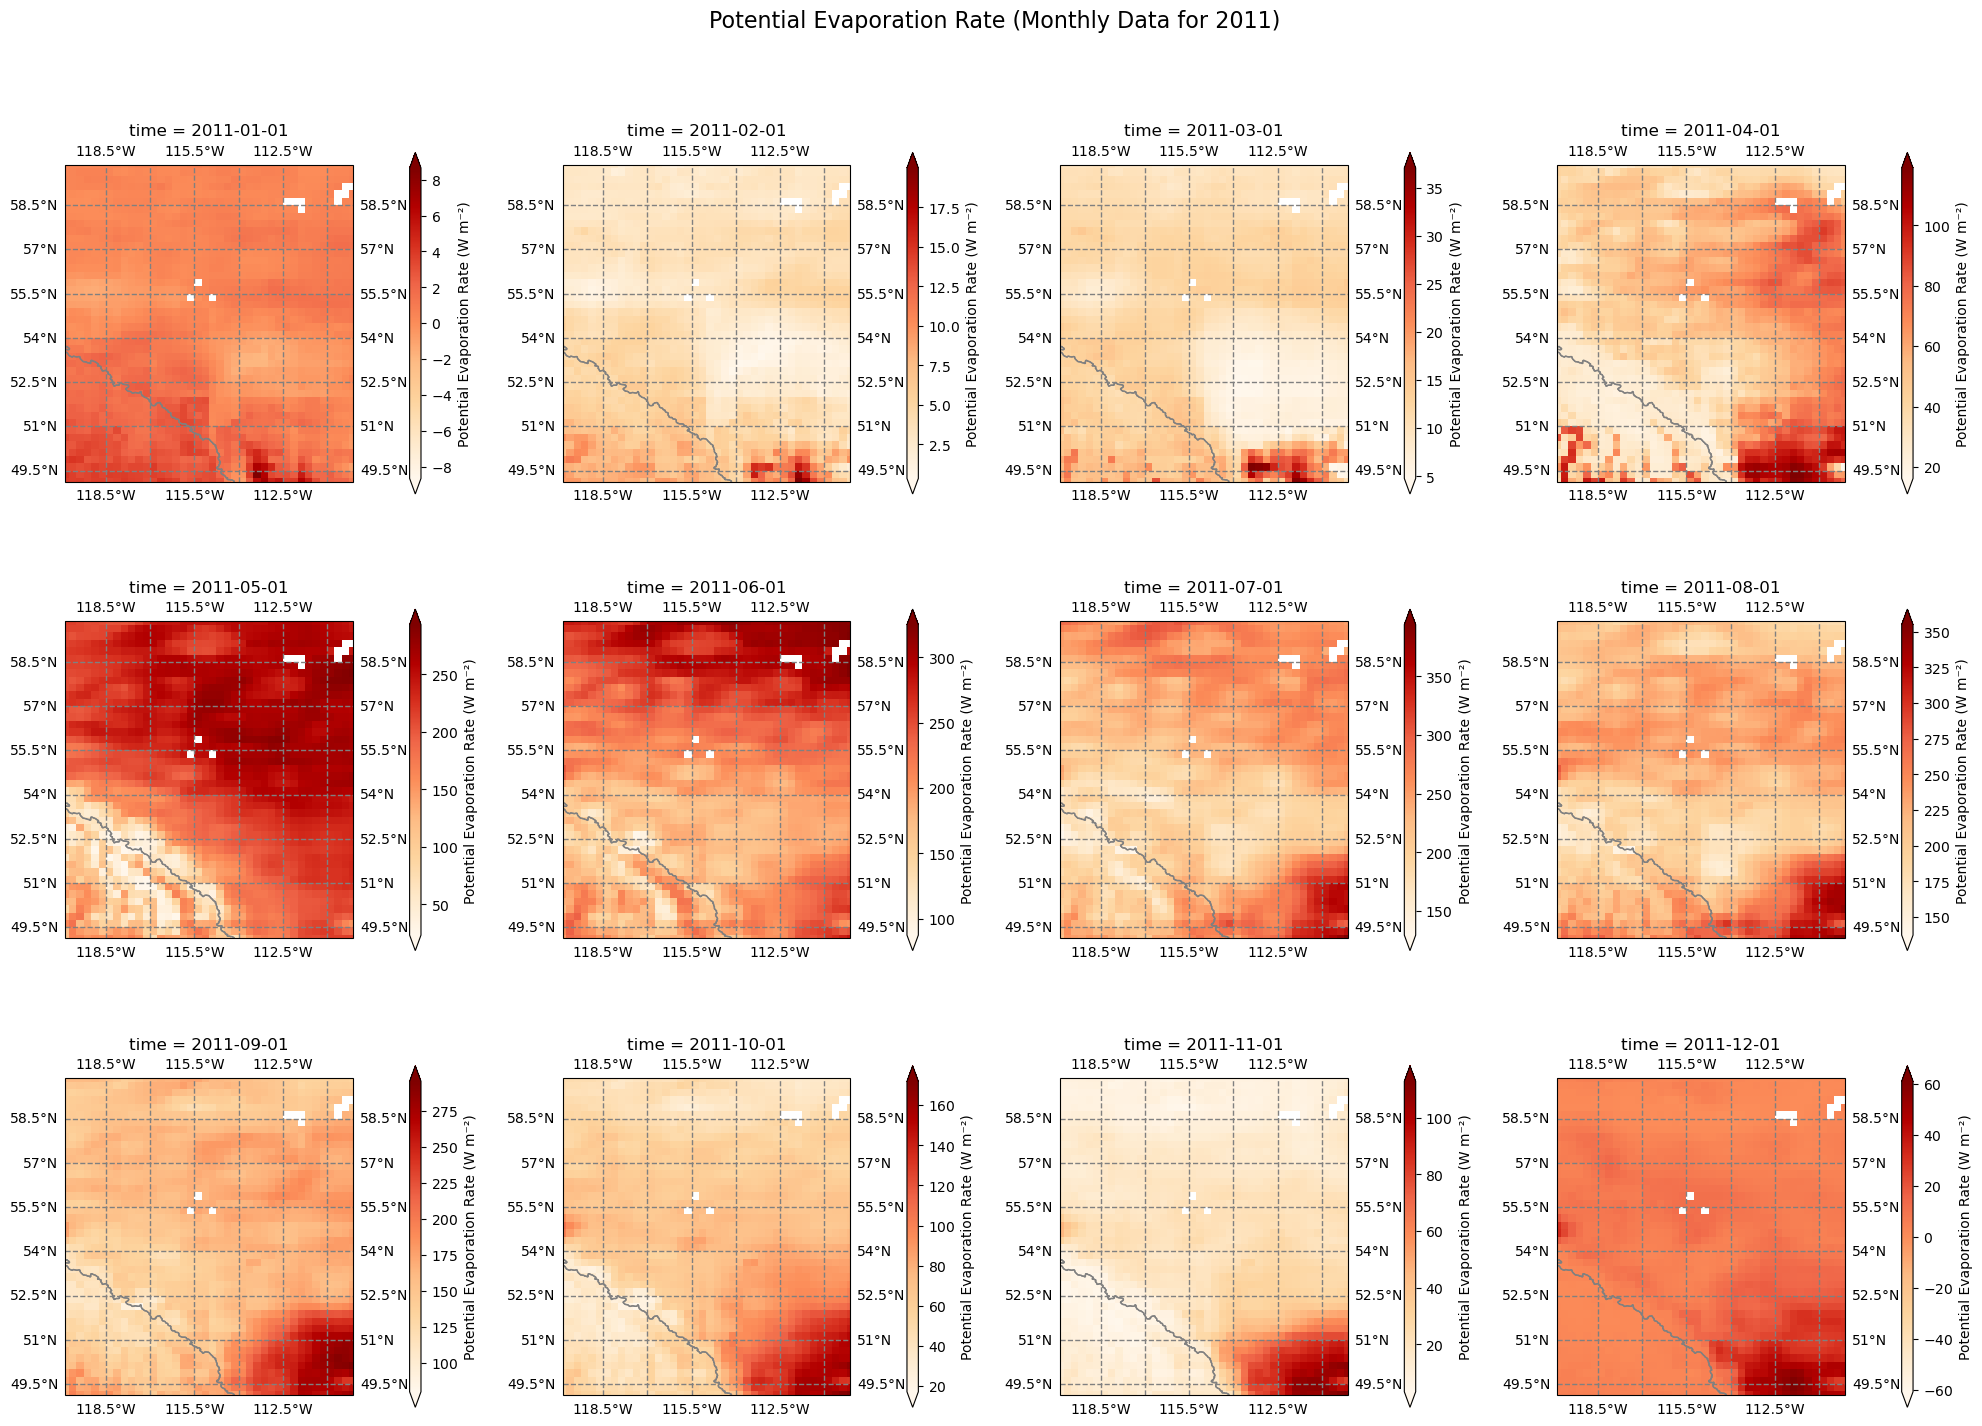

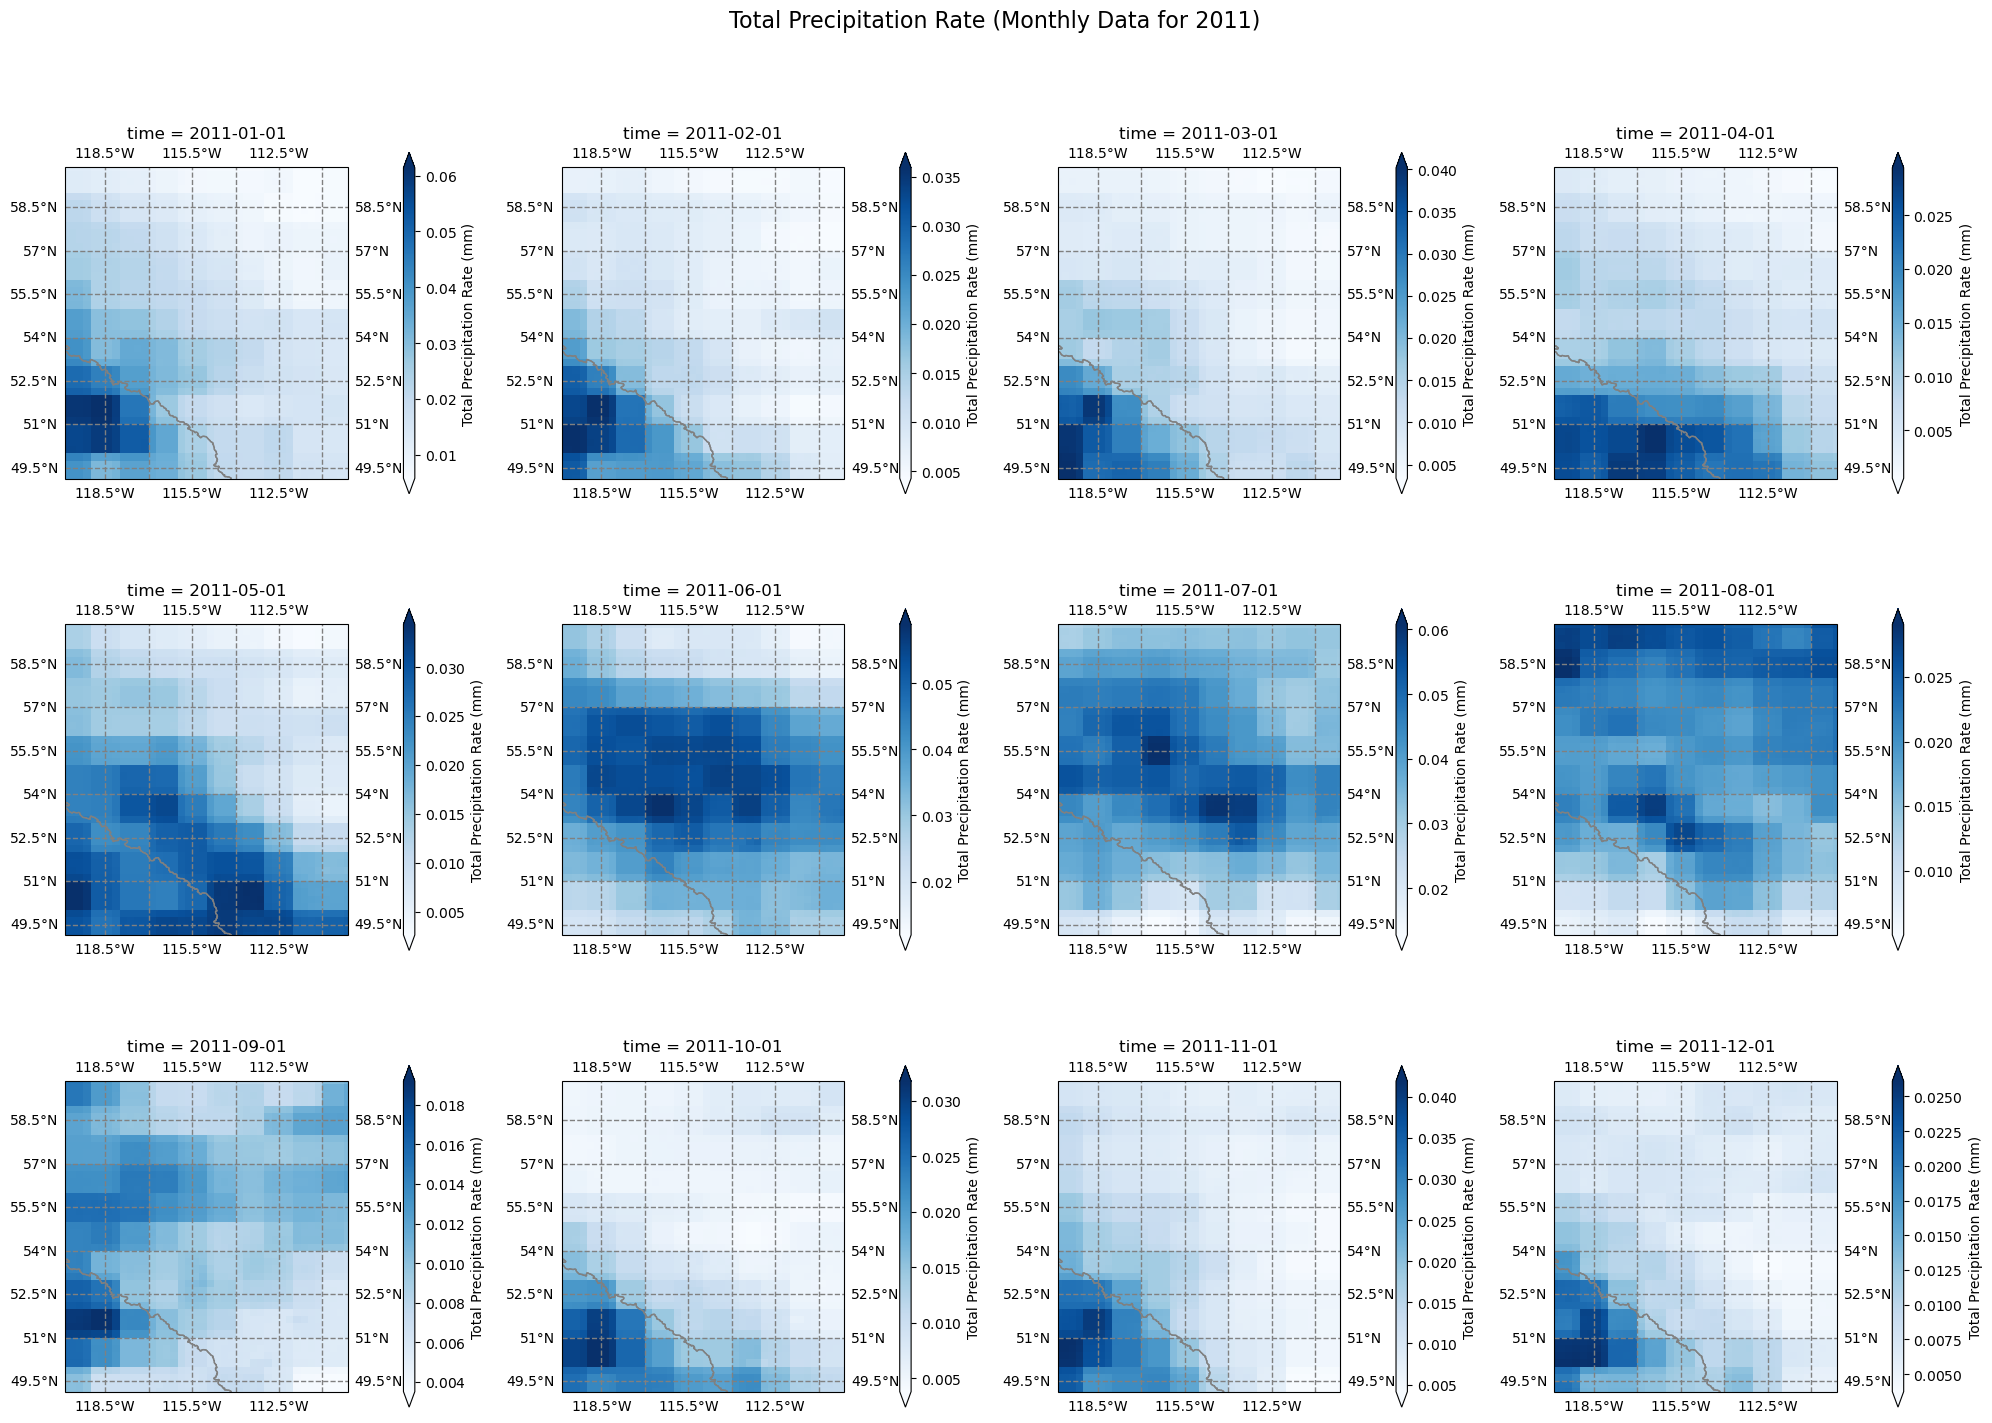

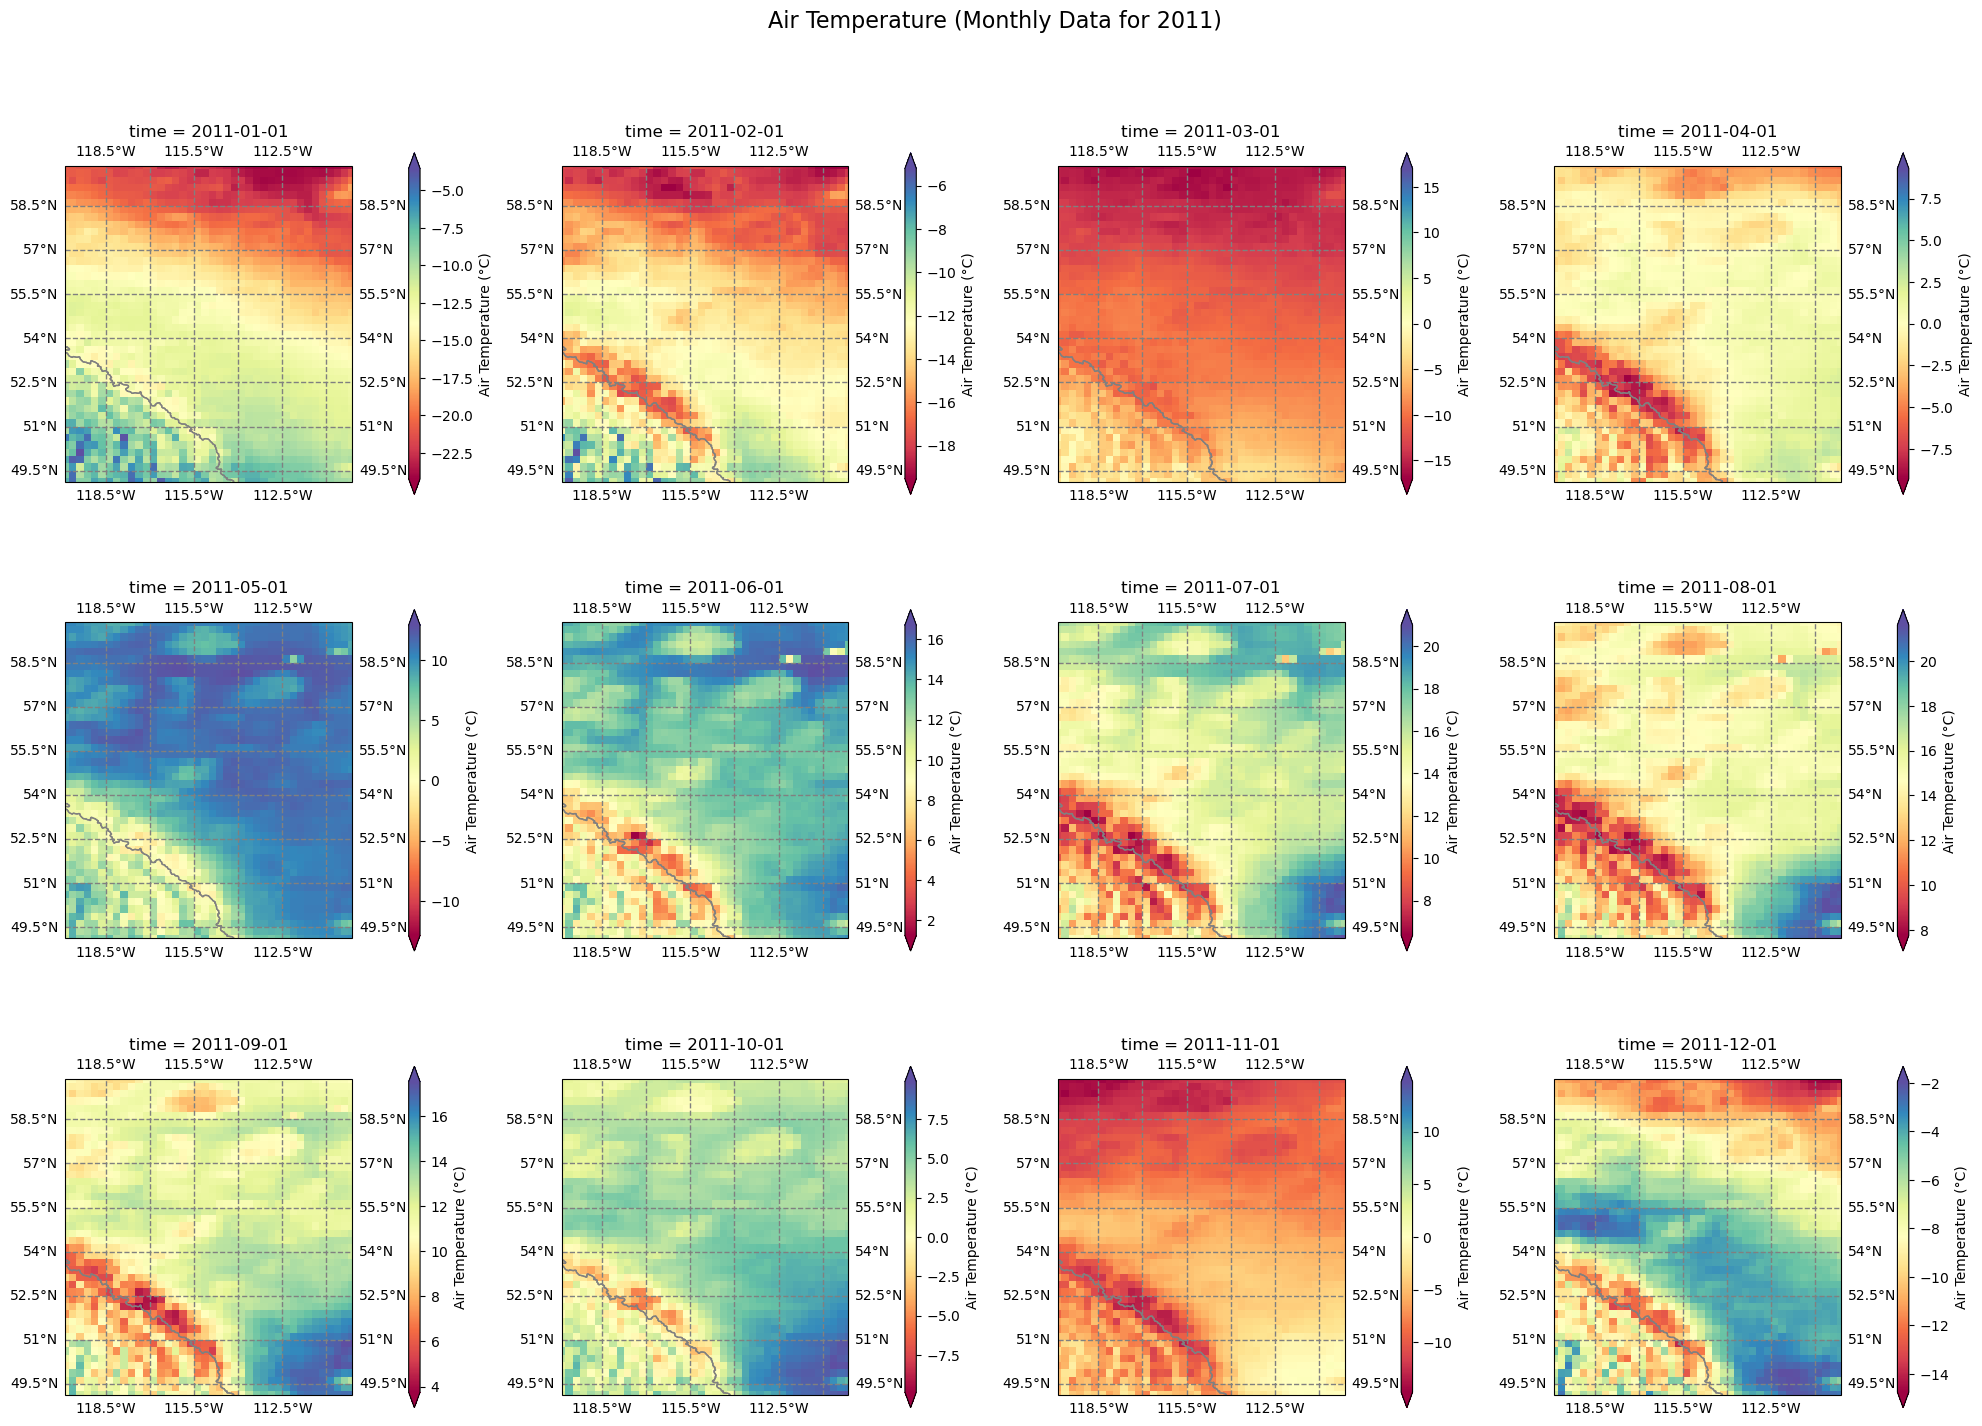

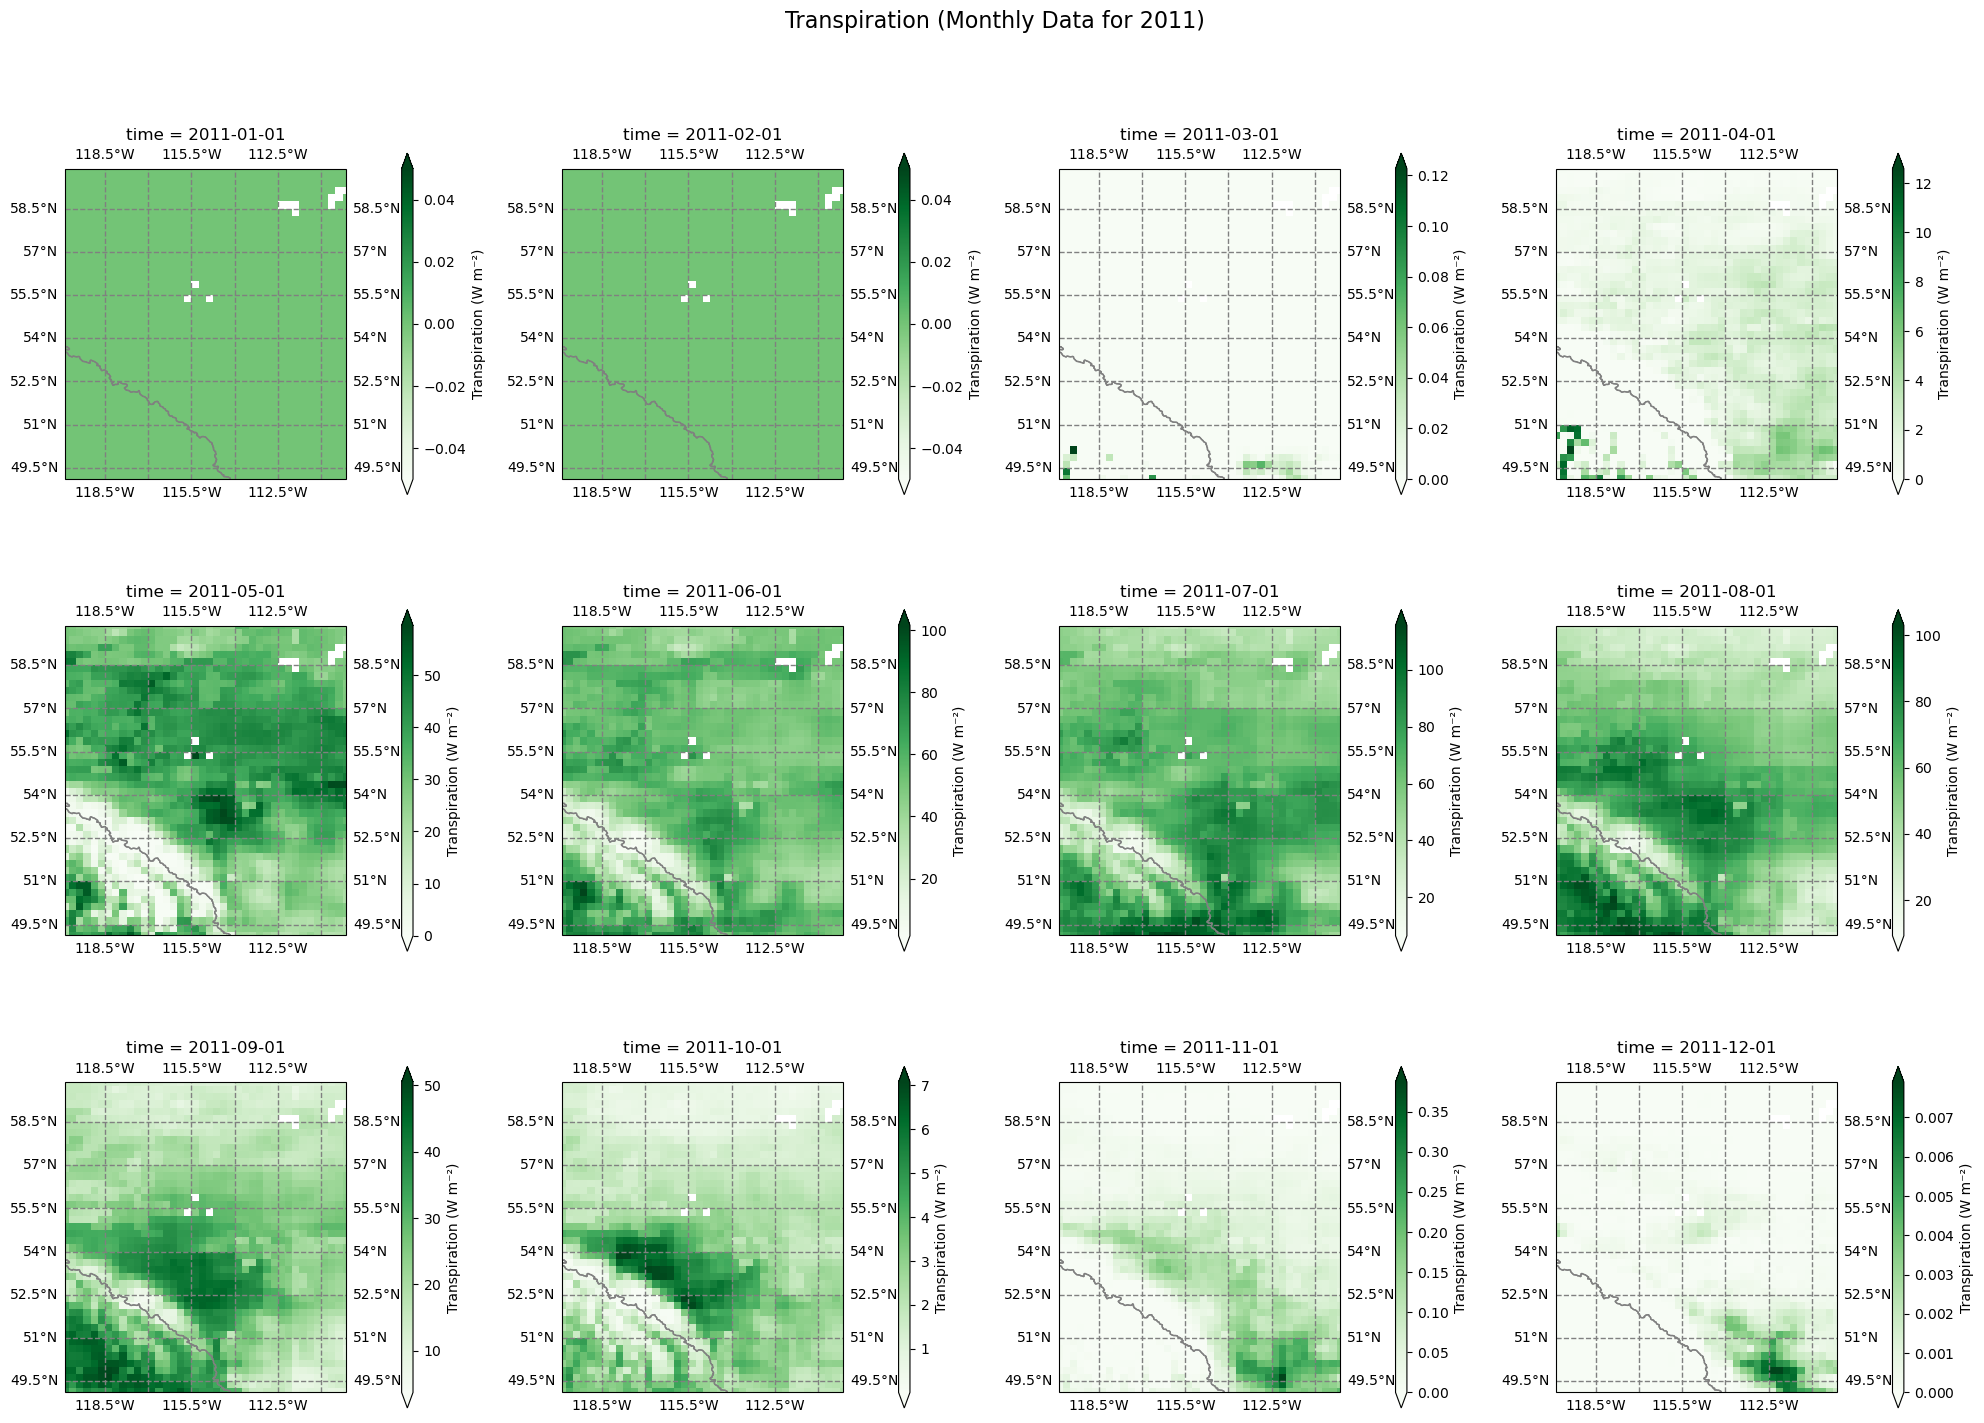

In [3]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import cartopy.feature as cfeature
from matplotlib.ticker import ScalarFormatter

# Define the directory containing the files
directory = r"C:\Users\DELL\OneDrive - iitr.ac.in\Documents\hydrclimatology_project"

# List all NetCDF files matching the naming pattern
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.nc4')]

# Load all datasets into a list
all_datasets = []
for file in files:
    try:
        ds = xr.open_dataset(file)
        all_datasets.append(ds)
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Variable descriptions (titles, units, colormap)
var_info = {
    'Albedo_inst': ('Albedo', '%', 'cividis'),
    'AvgSurfT_inst': ('Average Surface Skin Temperature', '°C', 'plasma'),
    'CanopInt_inst': ('Plant Canopy Surface Water', 'kg m⁻²', 'YlGn'),
    'ECanop_tavg': ('Canopy Water Evaporation', 'W m⁻²', 'YlGnBu'),
    'ESoil_tavg': ('Direct Evaporation from Bare Soil', 'W m⁻²', 'coolwarm'),
    'Evap_tavg': ('Evapotranspiration', 'kg m⁻² s⁻¹', 'viridis'),
    'PotEvap_tavg': ('Potential Evaporation Rate', 'W m⁻²', 'OrRd'),
    'Rainf_f_tavg': ('Total Precipitation Rate', 'mm', 'Blues'),
    'Tair_f_inst': ('Air Temperature', '°C', 'Spectral'),
    'Tveg_tavg': ('Transpiration', 'W m⁻²', 'Greens')
}

# Function to plot a variable for all months in 2011
def plot_variable(variable_name):
    if variable_name not in var_info:
        print(f"Variable {variable_name} not found in the dataset.")
        return

    title, units, cmap = var_info[variable_name]

    # Combine the variable data across all datasets
    monthly_data = []
    for ds in all_datasets:
        if variable_name in ds:
            try:
                var = ds[variable_name]
                var['time'] = pd.to_datetime(var['time'].values)  # Ensure time is in datetime format
                # Precipitation in kg/m²/s to mm conversion (multiply by 1000)
                if variable_name == 'Rainf_f_tavg':
                    var *= 1000  # Convert from kg/m²/s to mm (1 kg = 1 mm)
                # Convert temperature from Kelvin to Celsius
                if variable_name in ['AvgSurfT_inst', 'Tair_f_inst']:
                    var -= 273.15  # Convert from Kelvin to Celsius
                monthly_data.append(var)
            except Exception as e:
                print(f"Error processing variable {variable_name} in dataset: {e}")

    if not monthly_data:
        print(f"No valid data found for variable {variable_name}.")
        return

    combined_var = xr.concat(monthly_data, dim='time')

    # Filter for the year 2011
    var_2011 = combined_var.sel(time=slice('2011-01-01', '2011-12-31'))

    # Extract dynamic extent
    lats = var_2011.lat.values
    lons = var_2011.lon.values
    lat_min, lat_max = lats.min(), lats.max()
    lon_min, lon_max = lons.min(), lons.max()

    # Plotting
    fig, axes = plt.subplots(3, 4, figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    for month_idx in range(12):
        try:
            month_data = var_2011.isel(time=month_idx)  # Select data for the current month

            ax = axes[month_idx]
            ax.set_title(f"Month {month_idx + 1}", fontsize=12)

            # Plot the data
            month_data.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                cbar_kwargs={
                    'label': f"{title} ({units})",
                    'shrink': 0.75,       # Shrink the color bar
                    'aspect': 30,         # Control aspect ratio to avoid overlap
                    'extend': 'both',     # Extend color bar for out-of-range values
                    'pad': 0.14,          # Add a little gap for colorbar
                    'format': ScalarFormatter(useMathText=True)  # Handle scientific notation
                }
            )

            # Add features
            ax.coastlines()
            ax.add_feature(cfeature.STATES, edgecolor='gray')
            ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
            ax.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--')

        except Exception as e:
            print(f"Error plotting {variable_name} for Month {month_idx + 1}: {e}")

    plt.suptitle(f"{title} (Monthly Data for 2011)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
for variable in var_info.keys():
    plot_variable(variable)


<h2>Yearly Trend Analysis of Climatic variables</h2>

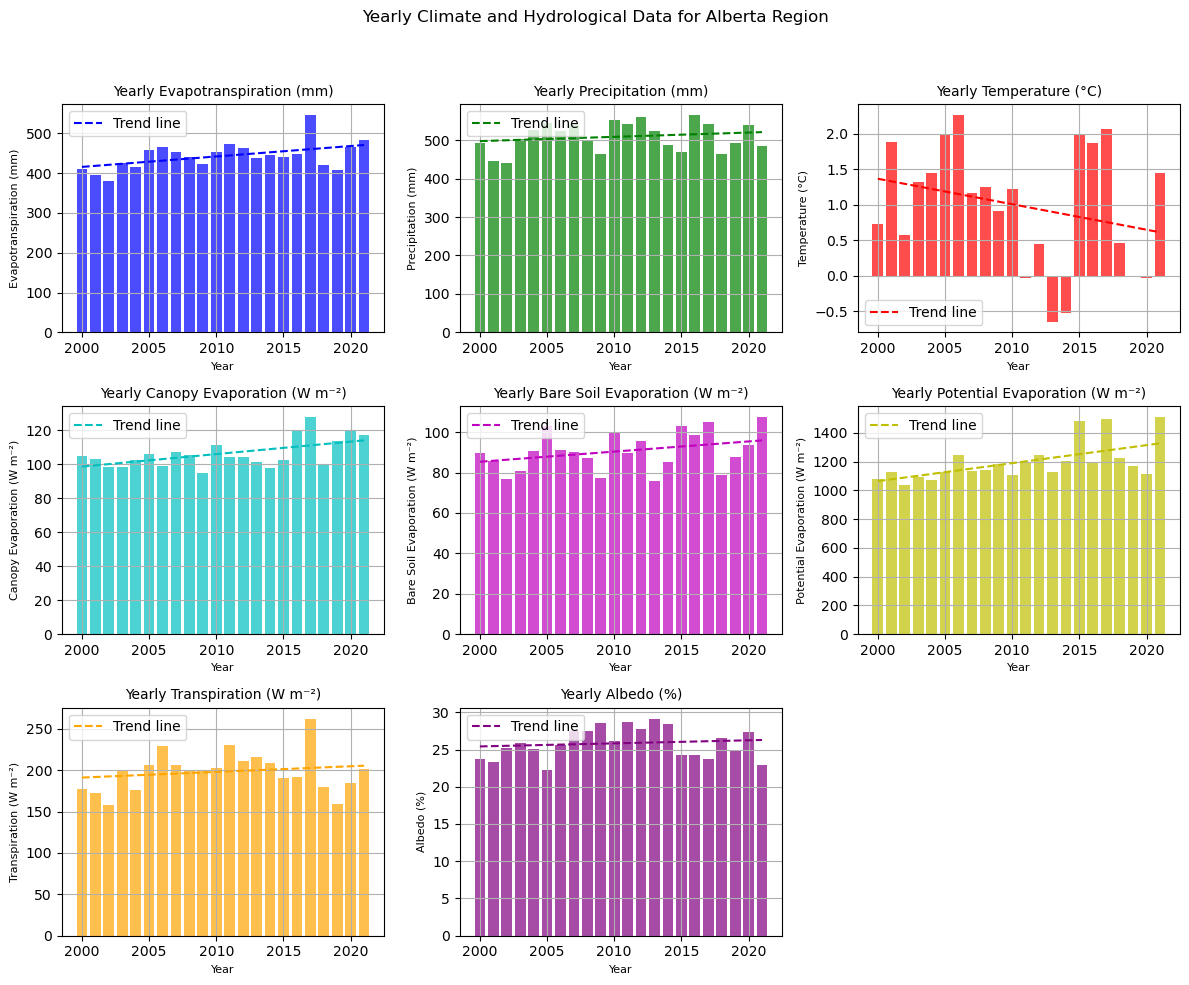

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
from sklearn.linear_model import LinearRegression

# Load the dataset
t = xr.open_dataset(r"C:\Users\DELL\OneDrive - iitr.ac.in\Documents\hydrclimatology_project\combined_data.nc")

# Convert time to datetime format
t['time'] = pd.to_datetime(t['time'].values)

# Convert Evap_tavg from kg/m²/s to mm/month (Evapotranspiration)
t['Evap_tavg_mm_month'] = t['Evap_tavg'] * 86400 * 30  # Convert to mm/month

# Convert Rainf_f_tavg from kg/m²/s to mm/month (Precipitation)
t['Rainf_f_tavg_mm_month'] = t['Rainf_f_tavg'] * 86400 * 30  # Convert to mm/month

# Convert temperature from Kelvin to Celsius
t['AvgSurfT_inst_C'] = t['AvgSurfT_inst'] - 273.15  # Convert to Celsius
t['Tair_f_inst_C'] = t['Tair_f_inst'] - 273.15  # Convert to Celsius

# Step 1: Resample the data by year and calculate the yearly sum for each variable
evap_yearly = t['Evap_tavg_mm_month'].resample(time='Y').sum()  # Sum for each year (in mm/month)
precip_yearly = t['Rainf_f_tavg_mm_month'].resample(time='Y').sum()  # Sum for each year (in mm/month)
temp_yearly = t['AvgSurfT_inst_C'].resample(time='Y').mean()  # Mean for temperature over the year
canopy_evap_yearly = t['ECanop_tavg'].resample(time='Y').sum()  # Canopy evaporation (W m⁻²)
bare_soil_evap_yearly = t['ESoil_tavg'].resample(time='Y').sum()  # Bare soil evaporation (W m⁻²)
pot_evap_yearly = t['PotEvap_tavg'].resample(time='Y').sum()  # Potential evaporation rate (W m⁻²)
transp_yearly = t['Tveg_tavg'].resample(time='Y').sum()  # Transpiration (W m⁻²)
albedo_yearly = t['Albedo_inst'].resample(time='Y').mean()  # Albedo (percentage)

# Step 2: Now, calculate the mean over latitude and longitude for each year
evap_yearly_mean = evap_yearly.mean(dim=('lat', 'lon'))  # Spatial mean across lat and lon for each year
precip_yearly_mean = precip_yearly.mean(dim=('lat', 'lon'))  # Spatial mean across lat and lon for each year
temp_yearly_mean = temp_yearly.mean(dim=('lat', 'lon'))  # Spatial mean across lat and lon for each year
canopy_evap_yearly_mean = canopy_evap_yearly.mean(dim=('lat', 'lon'))
bare_soil_evap_yearly_mean = bare_soil_evap_yearly.mean(dim=('lat', 'lon'))
pot_evap_yearly_mean = pot_evap_yearly.mean(dim=('lat', 'lon'))
transp_yearly_mean = transp_yearly.mean(dim=('lat', 'lon'))
albedo_yearly_mean = albedo_yearly.mean(dim=('lat', 'lon'))

# Step 3: Create a DataFrame for easier plotting
yearly_data = pd.DataFrame({
    'Year': evap_yearly_mean.time.dt.year,
    'Evapotranspiration (mm)': evap_yearly_mean.values,
    'Precipitation (mm)': precip_yearly_mean.values,
    'Temperature (°C)': temp_yearly_mean.values,
    'Canopy Evaporation (W m⁻²)': canopy_evap_yearly_mean.values,
    'Bare Soil Evaporation (W m⁻²)': bare_soil_evap_yearly_mean.values,
    'Potential Evaporation (W m⁻²)': pot_evap_yearly_mean.values,
    'Transpiration (W m⁻²)': transp_yearly_mean.values,
    'Albedo (%)': albedo_yearly_mean.values
})

# Step 4: Plotting the results in bar plots with larger size and displaying all years with a trend line
fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # 3x3 grid for all variables

# Function to add trend line
def plot_trend_line(x, y, ax, color):
    # Reshape data for linear regression
    x_reshaped = x.values.reshape(-1, 1)
    model = LinearRegression().fit(x_reshaped, y.values)
    y_pred = model.predict(x_reshaped)
    
    ax.plot(x, y_pred, color=color, linestyle='--',label='Trend line')
    return model

# Plot for each variable
variables = [
    ('Evapotranspiration (mm)', 'b'),
    ('Precipitation (mm)', 'g'),
    ('Temperature (°C)', 'r'),
    ('Canopy Evaporation (W m⁻²)', 'c'),
    ('Bare Soil Evaporation (W m⁻²)', 'm'),
    ('Potential Evaporation (W m⁻²)', 'y'),
    ('Transpiration (W m⁻²)', 'orange'),
    ('Albedo (%)', 'purple')
]

for idx, (var_name, color) in enumerate(variables):
    ax = axes[idx // 3, idx % 3]  # 3x3 grid layout
    ax.bar(yearly_data['Year'], yearly_data[var_name], color=color, alpha=0.7)
    ax.set_title(f'Yearly {var_name}', fontsize=10)
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel(var_name, fontsize=8)  # Change label units to mm
    ax.grid(True)

    # Add trend line
    plot_trend_line(yearly_data['Year'], yearly_data[var_name], ax, color)
    ax.legend()
fig.delaxes(axes[2, 2])  
# Add the main title
plt.suptitle("Yearly Climate and Hydrological Data for Alberta Region", fontsize=12,y=0.98)# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
